# Setup

In [ ]:
pip install tensorflow tensorflow_datasets keras_cv tensorboard thisnotthat seaborn umap faiss-cpu jupyter_bokeh tqdm

## Download data and visualise samples

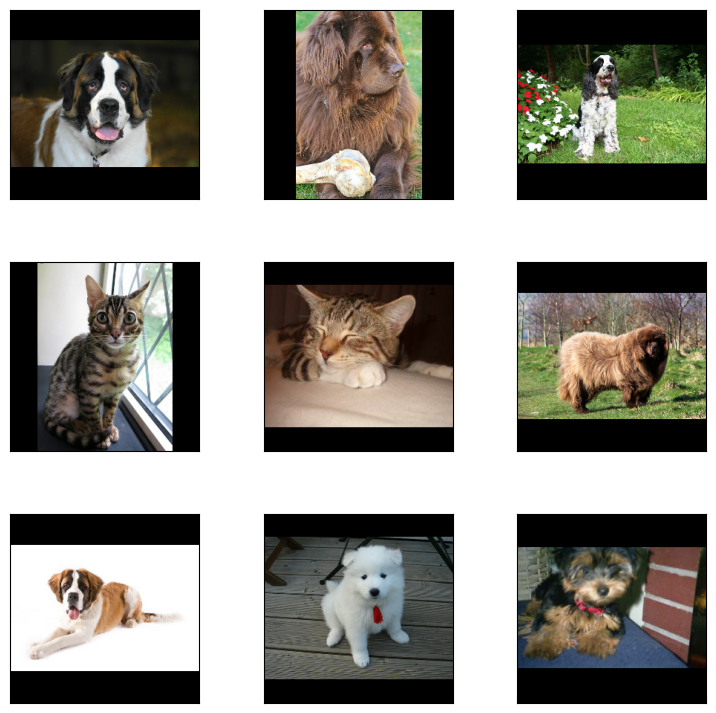

# Classes: 37
# Train: 3680 # Test: 3669


In [84]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load dataset
(train_data, test_data), info = tfds.load(name="oxford_iiit_pet", split=['train', 'test'], with_info=True)

def preprocess_data(sample, image_size = (256,256)):
    image = sample['image']
    if image.shape[:-1] != image_size:
        image = tf.image.resize(image, image_size, preserve_aspect_ratio=True)
        image = tf.image.resize_with_crop_or_pad(image, *image_size)
    image = tf.cast(image, tf.float32) / 255.0
    label = sample['label']
    return image, label

train_data = train_data.map(preprocess_data)
test_data = test_data.map(preprocess_data)
num_classes = info.features["label"].num_classes

fig = tfds.show_examples(train_data.shuffle(buffer_size=32), info, image_key="image")
print("# Classes:", info.features["label"].num_classes)
print("# Train:", len(train_data), "# Test:", len(test_data))

basepath = "./"

## Data to Vector

In [85]:
import os
import keras_cv
import tensorflow as tf

always_train = False
model_path = f"{basepath}/model.h5"

if always_train or (not os.path.exists(model_path)):
    # Construct an EfficientNetV2 from a preset:
    efficientnet = keras_cv.models.EfficientNetV2Backbone.from_preset(
        "efficientnetv2_b0_imagenet"
    )
    for layer in efficientnet.layers:
        layer.trainable = True

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(model_path, save_weights_only=False, save_best_only=False, save_freq='epoch')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"{basepath}/logs", histogram_freq=1)


    # Define additional layers for a classification
    model = tf.keras.Sequential([
        efficientnet,
        tf.keras.layers.GlobalAveragePooling2D(), # 1280 Embedding Vector
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.summary()
    train_data_b = train_data.batch(32)
    test_data_b = test_data.batch(32)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_data_b, epochs=2, validation_data=test_data_b, callbacks=[checkpoint_callback, tensorboard_callback])
    model.save(model_path)

model = tf.keras.models.load_model(model_path)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./logs

In [87]:
import numpy as np
from tqdm import tqdm

vector_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
vector_model.summary()

inferences = []
# Iterate through train_data and obtain predictions using our vector_model
for images, labels in tqdm(train_data.batch(1024), total= len(train_data)//1024+1):
    prediction = vector_model.predict(images, verbose=None)
    inferences.append((prediction, labels, images))

vectors, labels, images = zip(*inferences)
data = np.vstack(vectors)
labels = np.hstack([np.asarray(l) for l in labels])
images = np.vstack(images)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficient_net_v2b0_backbon  [(None, None, None, 3)]   0         
 e_input (InputLayer)                                            
                                                                 
 efficient_net_v2b0_backbon  (None, None, None, 1280   5919312   
 e (EfficientNetV2Backbone)  )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                           

  0%|          | 0/4 [00:00<?, ?it/s]Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
100%|██████████| 4/4 [06:53<00:00, 103.25s/it]


## Vector to Map

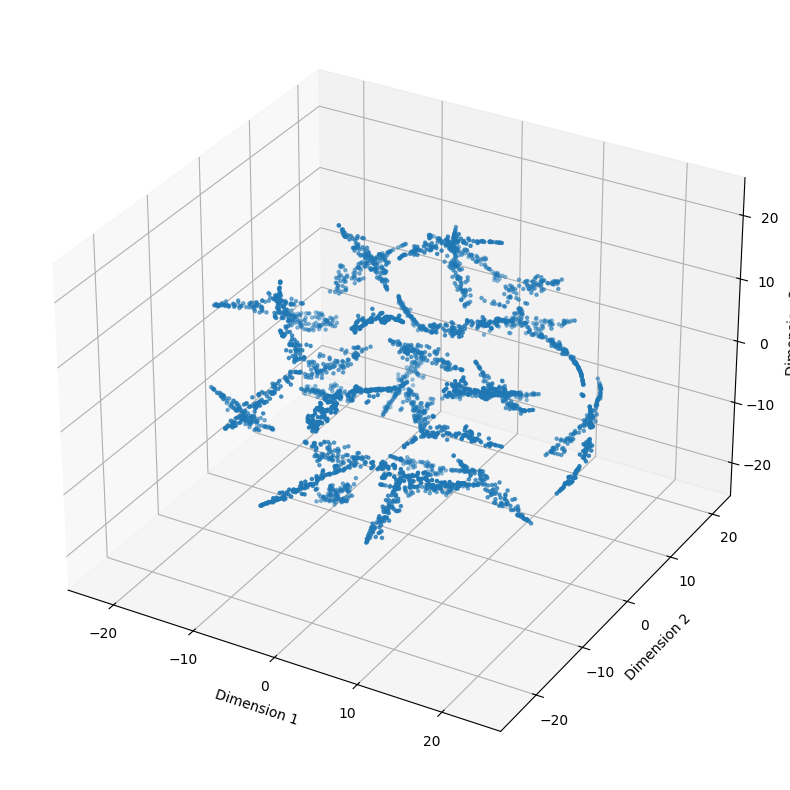

embedded_data.shape: (3680, 3)


In [88]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Compute pairwise distances between data points
distance_matrix = np.array([[np.linalg.norm(x - y) for y in data] for x in data])

# Perform t-SNE dimensionality reduction to 3D
tsne = TSNE(n_components=3)
embedded_data = tsne.fit_transform(distance_matrix)

# Plot the low dimension data
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], marker='.')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.show()

print("embedded_data.shape:", embedded_data.shape)

## Map annotation

# Clusters: 40


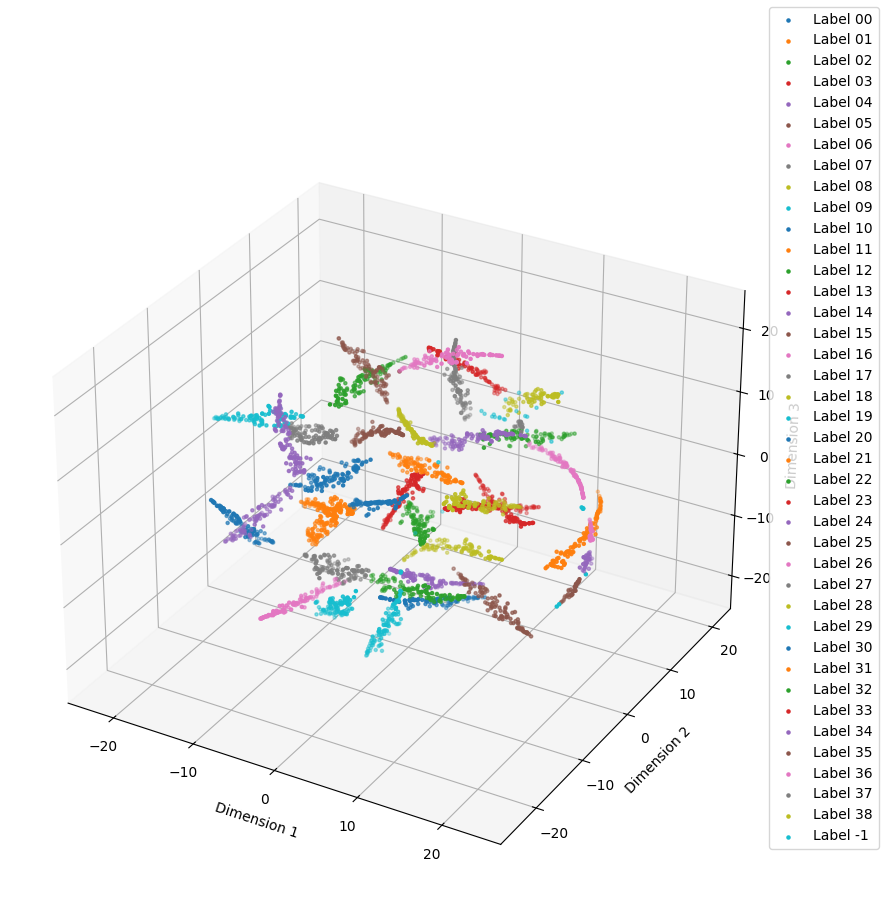

In [89]:
from sklearn.cluster import HDBSCAN

# Perform the clustering
clusterer = HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(embedded_data)

# Get unique cluster labels
unique_labels = set(cluster_labels)

# Group data by cluster label
cluster_data = {label: embedded_data[cluster_labels == label] for label in unique_labels}

# Plot the clustered data
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for label, datum in cluster_data.items():
    ax.scatter(datum[:, 0], datum[:, 1], datum[:, 2], marker='.', label=f"Label {label:02}")
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
fig.legend()

print("# Clusters:", len(unique_labels))


## Map Visualization

In [90]:
import base64
import pandas as pd
from PIL import Image
import numpy as np
import io

b64imgs = []
for img in images:
    image_stream = io.BytesIO()
    Image.fromarray((img*255).astype(np.uint8)).save(image_stream, format='JPEG')
    image_stream.seek(0)

    b64img = str(base64.b64encode(image_stream.read())).replace("\\n", "").replace("b'", "").replace("'", "")
    b64imgs.append(b64img)

titles = [f"Category {i}" for i in labels]
df = pd.DataFrame({'title': titles, 'image': b64imgs})

df

,title,image
0,Category 33,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,Category 12,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,Category 9,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,Category 32,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,Category 33,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
...,...,...
3675,Category 13,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3676,Category 3,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3677,Category 1,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3678,Category 17,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [94]:
from IPython.display import display, HTML
display(HTML("<style>.bk-Figure { width:100% !important; }</style>"))

import thisnotthat as tnt
import panel as pn

pn.extension('tabulator', design='material', template='material', loading_indicator=True)

template = """
# {title}

---

![Penguin Image](data:image/jpeg;base64,{image})

---

**All about the {title}:** Lorem ipsum dolor sit amet, consectetur adipiscing elit. Phasellus eget vehicula purus, nec tempor nulla. Donec pellentesque commodo libero, at congue ante. Pellentesque vulputate tempus lectus id finibus. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nam sed volutpat risus. Pellentesque aliquam augue nisl, at venenatis lorem sagittis eget. Morbi lacus dui, ultricies nec lorem at, ullamcorper convallis dolor. 


"""
info = tnt.InformationPane(
    raw_dataframe=df,
    markdown_template=template,
    width=500,
)


plot = tnt.BokehPlotPane(
    embedded_data,
    labels=[f"Label {l:02}" for l in labels],
    tools="pan,wheel_zoom,tap",
    width=700
)

info.link_to_plot(plot)
pn.Row(info, plot, width_policy="max")

/usr/local/lib/python3.11/site-packages/thisnotthat/instance_viewer.py:84: PanelDeprecationWarning: 'style' is deprecated and will be removed in version 1.4, use 'styles' instead.
  self.markdown = pn.pane.Markdown(


BokehModel(combine_events=True, render_bundle={'docs_json': {'9afeef0a-19c4-41c3-82a8-288d921b0030': {'version…

## Vector Search

In [92]:
import faiss
from random import randint

# Creating an index
index = faiss.IndexFlatL2(data.shape[-1])
index.add(data)

# Save the index to the hard drive
faiss.write_index(index, "faiss_index.faiss")

Indices of nearest neighbors: [[2160 1815  642 3311 1825 1891  367  358 1494]]
Distances to nearest neighbors: [[ 0.       26.244205 35.745518 39.128967 39.5033   41.721405 41.9029
  42.48115  45.449394]]


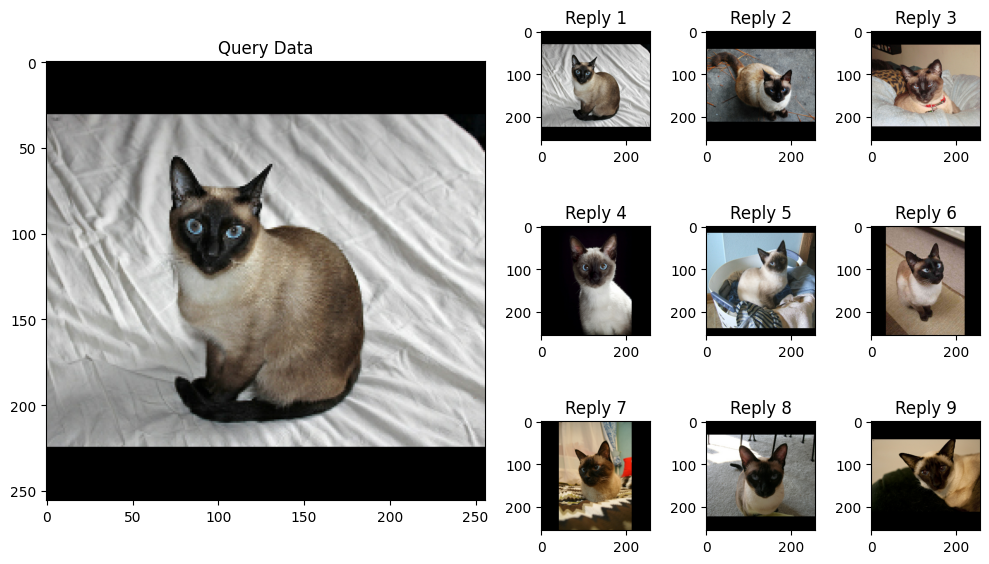

In [95]:
import matplotlib.pyplot as plt

query_idx = randint(0, data.shape[0])
k = 9  # Number of nearest neighbors to search for

# Load the index from the saved file
index = faiss.read_index("faiss_index.faiss")

# Performing a search
distances, indices = index.search(data[query_idx].reshape(1,-1), k)

print("Indices of nearest neighbors:", indices)
print("Distances to nearest neighbors:", distances)


# Plot the results
matched_images = (images[indices[0]])
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(3, 6)

axis = [fig.add_subplot(gs[:, :3])] + [fig.add_subplot(gs[i, j+3]) for i in range(3) for j in range(3)]

for i, ax in enumerate(axis):
    if i == 0:
        ax.imshow(images[query_idx])
        ax.set_title(f'Query Data')
    else:
        ax.imshow(matched_images[i-1,...])
        ax.set_title(f'Reply {i}')

plt.tight_layout()
plt.show()